# Load Best Segmentation Model and Pose detection

In [1]:
import cv2
import os
import torch
import numpy as np

from PIL import Image
from ultralytics import YOLO
from tqdm import tqdm
torch.cuda.set_device(0)
model_pose = YOLO("../model/yolov8n-pose.pt")
# model_det = YOLO("model/best-weight/best-segment-v2.pt")
model_det = YOLO("../model/best-weight2/best-v6-200.pt")
# model_det = YOLO("model/yolov8n-seg.pt")

# Create Testing Images

In [2]:
path_video_test = "E:\\test-segment\\test-video-muay-01.mp4"
path_img_test = os.path.join("input_tester",path_video_test.split("\\")[-1][:-4])
os.makedirs(path_img_test,exist_ok=True)
# Load Video File
cap = cv2.VideoCapture(path_video_test)
len_cap = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# Set the number of images selected to test
n = 30  # no. images selected
frame_step = int(len_cap/n)
selected_frame = [c*frame_step for c in range(1,n+1)]
# for i in tqdm(range(len_cap)):
#     ret, frame = cap.read()
#     if i in selected_frame:
#         cv2.imwrite(os.path.join(path_img_test,f"{i:06d}.png"), frame)
print("total number of frames : ",len_cap)
print("total number of images selected : ",n)

total number of frames :  31309
total number of images selected :  30



0: 384x640 1 Blue, 1 Red, 3 Refs, 85.5ms
Speed: 18.6ms preprocess, 85.5ms inference, 664.1ms postprocess per image at shape (1, 3, 384, 640)
4


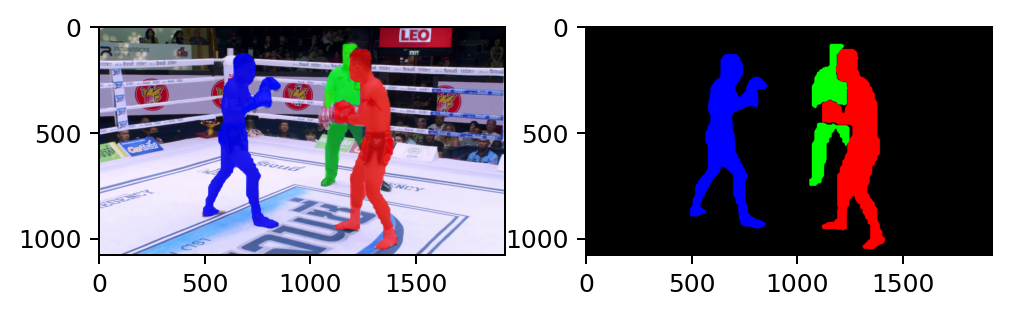

In [3]:
import matplotlib.pyplot as plt

def postprocess_prediction(prediction, class_color_mapping):
    masks=[]
    
    image = prediction.orig_img.copy()
    overlay = image.copy() 
    #collecting all masks after coloring them
    for i in range(len(prediction.boxes.cls)):
        color=class_color_mapping[int(prediction.boxes.cls[i])] # extracting custom color based on predicted class from class-color mapping 
        mask_points=prediction.masks[i].xy[0].astype(np.int32) # obtaining contours of mask from predicted image
        cv2.fillPoly(overlay, [mask_points], color); # filling background with mask contour using extracted color
    
        alpha = 0.3  # Transparency factor.
        image = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    return image

def maskmaker(prediction, class_color_mapping):
    masks=[]
    overlay = np.zeros_like(prediction.orig_img.copy())
    #collecting all masks after coloring them
    for i in range(len(prediction.boxes.cls)):
        color=class_color_mapping[int(prediction.boxes.cls[i])] # extracting custom color based on predicted class from class-color mapping 
        mask_points=prediction.masks[i].xy[0].astype(np.int32) # obtaining contours of mask from predicted image
        cv2.fillPoly(overlay, [mask_points], color); # filling background with mask contour using extracted color
    print(i)
    image = cv2.cvtColor(overlay,cv2.COLOR_BGR2RGB)
    return image

def crop_image_mask():
    
    return 0

cls_cmap = [[255,0,0],
            [0,0,255],
            [0,255,0]]

idx = 1
img_list = os.listdir(path_img_test)
img_test = cv2.imread(os.path.join(path_img_test,img_list[idx]))
results = model_det(img_test)
plot_masks = postprocess_prediction(results[0], cls_cmap)
plot_img = Image.fromarray(plot_masks)
masks = maskmaker(results[0], cls_cmap)
masks_img = Image.fromarray(masks)
fig,ax = plt.subplots(1,2,dpi=180)
ax[0].imshow(plot_img)
ax[1].imshow(masks_img)
plot_img.save("original_w_mask.png")
masks_img.save("original_masks.png")
plt.show()

In [5]:
results[0].boxes.cls

tensor([0., 2., 1., 2., 2.], device='cuda:0')

In [8]:
results[0].masks[1].xy[0]

array([[       1158,          84],
       [       1152,          90],
       [       1152,         183],
       [       1143,         192],
       [       1131,         192],
       [       1128,         195],
       [       1122,         195],
       [       1113,         204],
       [       1107,         204],
       [       1104,         207],
       [       1104,         210],
       [       1098,         216],
       [       1095,         216],
       [       1092,         219],
       [       1092,         225],
       [       1089,         228],
       [       1089,         231],
       [       1083,         237],
       [       1083,         240],
       [       1080,         243],
       [       1080,         264],
       [       1077,         267],
       [       1077,         270],
       [       1071,         276],
       [       1071,         279],
       [       1068,         282],
       [       1068,         375],
       [       1077,         384],
       [       1080,

In [68]:
def maskmaker2(prediction, i):
    color = 1
    overlay = np.zeros((prediction.orig_img.shape[0],prediction.orig_img.shape[1]))
    box_idx = np.argwhere(prediction.boxes.cls.cpu().numpy()==i).reshape(-1).astype(np.int32)
    print(box_idx)
    #collecting all masks after coloring them
    for bdx in box_idx:
        mask_points=prediction.masks[bdx].xy[0].astype(np.int32) # obtaining contours of mask from predicted image
        cv2.fillPoly(overlay, [mask_points], color); # filling background with mask contour using extracted color
    # image = cv2.cvtColor(overlay,cv2.COLOR_BGR2RGB)
    return overlay

def mask_extraction(prediction, idx):
    color=1
    overlay = np.zeros((prediction.orig_img.shape[0],prediction.orig_img.shape[1]))
    mask_points=prediction.masks[idx].xy[0].astype(np.int32)
    cv2.fillPoly(overlay, [mask_points], color); 
    return overlay

def get_img_mask(idx_cls,results):
    # masks_red = mask_extraction(results[0],idx_cls)
    masks_red = maskmaker2(results[0],idx_cls)
    masks_red = np.stack([masks_red,masks_red,masks_red],axis=-1)
    print(masks_red.shape)
    masked_img_red = (masks_red*cv2.cvtColor(results[0].orig_img,cv2.COLOR_BGR2RGB)).astype(np.uint8)
    # plt.imshow(masks_red)
    # plt.show()
    # plt.figure()
    # plt.imshow(masks_red)
    # plt.show()
    return masked_img_red

def display_extract_pose(idx,path_img_test,both=True,show_maksed=True):
    img_test = cv2.imread(os.path.join(path_img_test,img_list[idx]))
    results = model_det(img_test)
    img_crop_list = []
    if both:
        fig,ax = plt.subplots(2,3,dpi=200)
    else:
        fig,ax = plt.subplots(1,3,dpi=200)
    for k in range(3):  
        img_crop_ = get_img_mask(k,results)
        results_pose = model_pose(img_crop_)
        img_pose_ = results_pose[0].plot()
        if both:
            ax[0,k].imshow(img_crop_)
            ax[1,k].imshow(img_pose_)
            crop_used = Image.fromarray(img_crop_)
            pose_used = Image.fromarray(img_pose_)

            crop_used.save(f"{k}_crop_used.png")
            pose_used.save(f"{k}_pose_used.png")
        else:
            if show_maksed:
                ax[k].imshow(img_crop_)
            else:
                ax[k].imshow(img_pose_)
        img_crop_list.append(img_crop_)
    plt.show()
    return img_crop_

0: 384x640 1 Blue, 1 Red, 3 Refs, 195.0ms
Speed: 9.0ms preprocess, 195.0ms inference, 7.1ms postprocess per image at shape (1, 3, 384, 640)
[0]
(1080, 1920, 3)

0: 384x640 1 person, 117.0ms
Speed: 9.0ms preprocess, 117.0ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)
[2]
(1080, 1920, 3)

0: 384x640 1 person, 115.6ms
Speed: 8.0ms preprocess, 115.6ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)
[1 3 4]
(1080, 1920, 3)

0: 384x640 1 person, 115.7ms
Speed: 6.0ms preprocess, 115.7ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


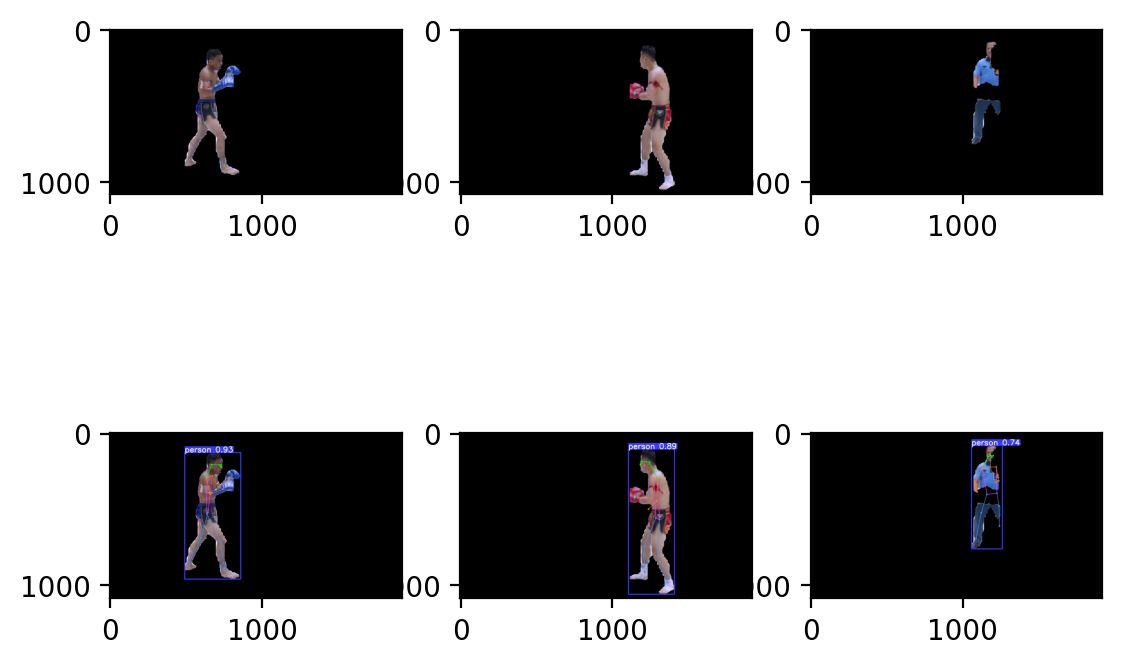

In [69]:
idx = 1
img_list = os.listdir(path_img_test)
img_crop_com = display_extract_pose(idx,path_img_test,both=True,show_maksed=True)


0: 384x640 1 Blue, 1 Red, 1 Ref, 155.6ms
Speed: 6.0ms preprocess, 155.6ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 19.9ms
Speed: 3.0ms preprocess, 19.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 19.9ms
Speed: 2.0ms preprocess, 19.9ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 19.0ms
Speed: 2.9ms preprocess, 19.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


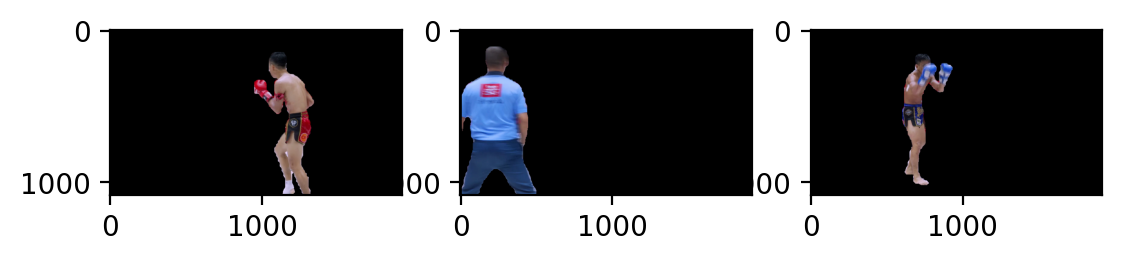

In [38]:
idx = 10
img_list = os.listdir(path_img_test)
img_crop_com = display_extract_pose(idx,path_img_test,both=False,show_maksed=True)


0: 384x640 1 Blue, 1 Red, 1 Ref, 193.5ms
Speed: 18.0ms preprocess, 193.5ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 20.0ms
Speed: 2.0ms preprocess, 20.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 19.9ms
Speed: 3.0ms preprocess, 19.9ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 19.9ms
Speed: 3.0ms preprocess, 19.9ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


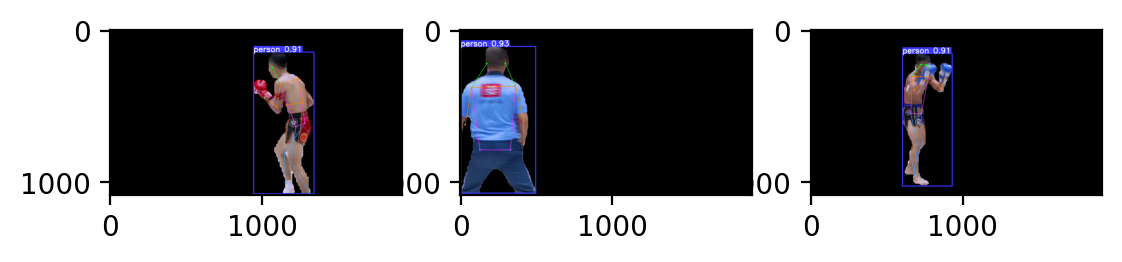

In [39]:
idx = 10
img_list = os.listdir(path_img_test)
img_crop_com = display_extract_pose(idx,path_img_test,both=False,show_maksed=False)


0: 384x640 2 Blues, 4 Reds, 1 Ref, 120.7ms
Speed: 4.0ms preprocess, 120.7ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 19.9ms
Speed: 2.0ms preprocess, 19.9ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 19.9ms
Speed: 2.0ms preprocess, 19.9ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 20.9ms
Speed: 2.0ms preprocess, 20.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


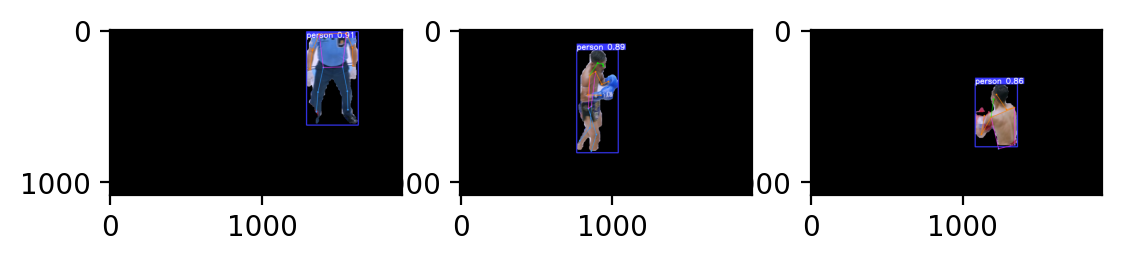

In [52]:
idx = 27
img_list = os.listdir(path_img_test)
img_crop_com = display_extract_pose(idx,path_img_test,both=False,show_maksed=False)